# 2023-09-08 14 - First glance exchange.ipynb
Plot a couple of exchange runs to gain an intuition on how hard it is. 

## Fetching runs

In [22]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer-javierdev"
workspace = "alelab"

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",{"$and": [{"name": {"$in": run_ids}},]})

def runs_into_df(runs):
    all_runs = []
    run_counter = 0
    for run in tqdm(runs):
        run_counter += 1
        for split in ["train", "test","val"]:
            for metric in ["mse",]:
                pred_len = run.config["pred_len"]
                metrics = np.zeros(pred_len)
                for i in range(pred_len):
                    run_dict = {**run.config}
                    #run_dict["constraint_level"] = constraint_level
                    run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                    #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                    run_dict["step"]=i
                    run_dict["epoch"]=run.summary["epoch"]
                    run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                    run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                    run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                    run_dict["split"] = split
                    run_dict["run_id"] = run.id
                    # Get either Constrained/ or ERM/ from the run name, then append model name.
                    #print("run.name", run.name)
                    #debug if ERM run
                    run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                    run_dict["sweep_id"] = run.sweep.id if run.sweep else ''
                    #print("Algorithm", run_dict["Algorithm"])

                    # Get the experiment tag
                    #run_dict["experiment_tag"] = tag_experiment(run)

                    # To better plot constrained vs ERM
                    #TODO this is a hack while I consolidate the tags. 
                    run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                    all_runs.append(run_dict)
    print(f"Fetched {run_counter} runs")
    df = pd.DataFrame(all_runs)
    print(f"Total records: {(df.shape)}")
    print(f"Total runs: {df.run_id.nunique()}")
    return df

100%|██████████| 2/2 [00:00<00:00, 137.04it/s]

Fetched 2 runs
Total records: (1152, 64)
Total runs: 2


In [23]:
df[['run_id',"sweep_id",'Algorithm',"type",'model','data_path','constraint_level','pred_len']].drop_duplicates().sort_values(['model',"pred_len","constraint_level"])

,run_id,sweep_id,Algorithm,type,model,data_path,constraint_level,pred_len
0,aigxwsjq,,ERM-Reformer-exchange Reformer,ERM,Reformer,exchange_rate.csv,-1.00,192
576,sqvz2f2s,,Constrained-Reformer-exchange Reformer,Constrained,Reformer,exchange_rate.csv,0.19,192


## Will using the proper constraint level affect the results?
Check with a single run of electricity 192. Generalizes pretty badly. constraint is probably too tight(just noticed that I got it from training mse.)

100%|██████████| 2/2 [00:00<00:00, 112.81it/s]


Fetched 2 runs
Total records: (1152, 64)
Total runs: 2


run_id     model          data_path constraint_level       mse  \
split                                                              test   
0      aigxwsjq  Reformer  exchange_rate.csv            -1.00  2.078309   
1      sqvz2f2s  Reformer  exchange_rate.csv             0.19  3.105896   

                           
split     train       val  
0      0.199631  2.050468  
1      0.228364  2.980070

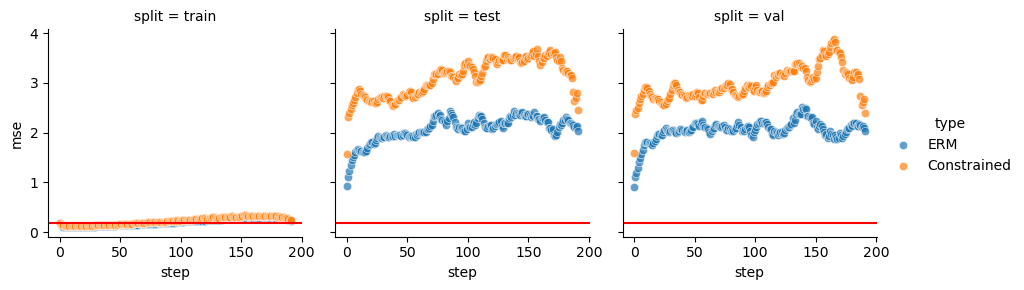

In [27]:

#df = df.query('split=="train"')
runs = api.runs(f"{workspace}/{project}",{"$and": [{"name": {"$in": [
    "sqvz2f2s", #constraint mean (with \eps= 0.19)
    "aigxwsjq", #ERM 
    #"v0f930e5", #dual init 0 probably garbage
]}},]})
df = runs_into_df(runs)
g = sns.FacetGrid(df, col="split", hue="type",col_wrap=3)
g.map(sns.scatterplot, "step", "mse", alpha=.7) 
g.add_legend()
# add the hline
data_summary=df.groupby(['run_id','model','data_path','split','constraint_level'])[['mse']].mean().reset_index()
# Pivot mse with columns based on split and reference
display(data_summary.pivot_table(index=['run_id','model','data_path','constraint_level'],columns=['split'],values=['mse']).reset_index())
for ax in g.axes:   
    ax.axhline(y=df.constraint_level[df.constraint_level>0].tolist()[0], color='r', linestyle='-')
plt.show()

With looser:

100%|██████████| 2/2 [00:00<00:00, 104.13it/s]


Fetched 2 runs
Total records: (1152, 64)
Total runs: 2


run_id     model          data_path constraint_level       mse  \
split                                                              test   
0      aigxwsjq  Reformer  exchange_rate.csv               -1  2.078309   
1      hgyl7324  Reformer  exchange_rate.csv                2  2.983160   

                           
split     train       val  
0      0.199631  2.050468  
1      0.312110  3.010195

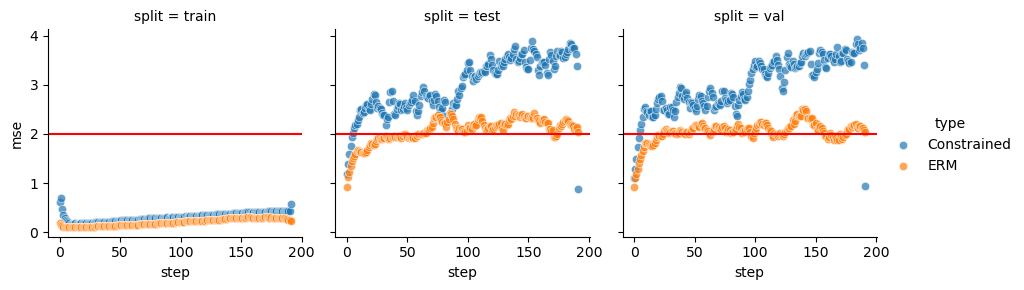

In [28]:

#df = df.query('split=="train"')
runs = api.runs(f"{workspace}/{project}",{"$and": [{"name": {"$in": [
    "hgyl7324", #constraint mean (with \eps= 2)
    "aigxwsjq", #ERM 
    #"v0f930e5", #dual init 0 probably garbage
]}},]})
df = runs_into_df(runs)
g = sns.FacetGrid(df, col="split", hue="type",col_wrap=3)
g.map(sns.scatterplot, "step", "mse", alpha=.7) 
g.add_legend()
# add the hline
data_summary=df.groupby(['run_id','model','data_path','split','constraint_level'])[['mse']].mean().reset_index()
# Pivot mse with columns based on split and reference
display(data_summary.pivot_table(index=['run_id','model','data_path','constraint_level'],columns=['split'],values=['mse']).reset_index())
for ax in g.axes:   
    ax.axhline(y=df.constraint_level[df.constraint_level>0].tolist()[0], color='r', linestyle='-')
plt.show()

100%|██████████| 2/2 [00:00<00:00, 105.25it/s]


Fetched 2 runs
Total records: (1152, 64)
Total runs: 2


run_id     model          data_path constraint_level       mse  \
split                                                              test   
0      gtwu3rrt  Reformer  exchange_rate.csv               -1  2.882761   
1      hgyl7324  Reformer  exchange_rate.csv                2  2.983160   

                          
split    train       val  
0      0.21179  2.948056  
1      0.31211  3.010195

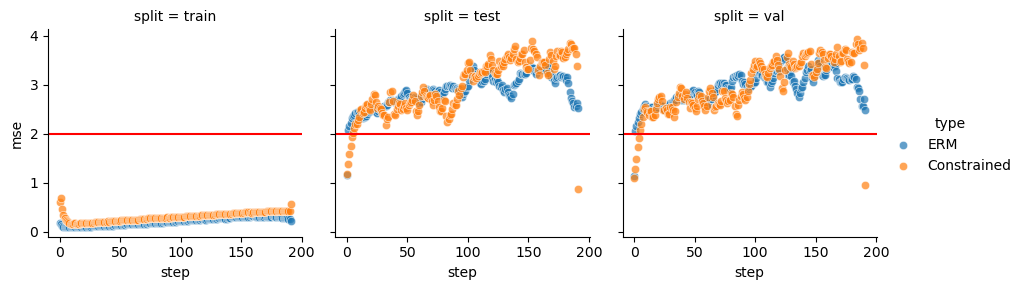

In [29]:
#df = df.query('split=="train"')
runs = api.runs(f"{workspace}/{project}",{"$and": [{"name": {"$in": [
    "hgyl7324", #constraint mean (with \eps= 2)
    "gtwu3rrt", #ERM fixed bug
    #"v0f930e5", #dual init 0 probably garbage
]}},]})
df = runs_into_df(runs)
g = sns.FacetGrid(df, col="split", hue="type",col_wrap=3)
g.map(sns.scatterplot, "step", "mse", alpha=.7) 
g.add_legend()
# add the hline
data_summary=df.groupby(['run_id','model','data_path','split','constraint_level'])[['mse']].mean().reset_index()
# Pivot mse with columns based on split and reference
display(data_summary.pivot_table(index=['run_id','model','data_path','constraint_level'],columns=['split'],values=['mse']).reset_index())
for ax in g.axes:   
    ax.axhline(y=df.constraint_level[df.constraint_level>0].tolist()[0], color='r', linestyle='-')
plt.show()

100%|██████████| 2/2 [00:00<00:00, 93.92it/s]


Fetched 2 runs
Total records: (1152, 64)
Total runs: 2


run_id     model          data_path constraint_level       mse  \
split                                                              test   
0      gtwu3rrt  Reformer  exchange_rate.csv               -1  2.882761   
1      jvqvoczj  Reformer  exchange_rate.csv                2  2.202675   

                           
split     train       val  
0      0.211790  2.948056  
1      0.189167  2.301868

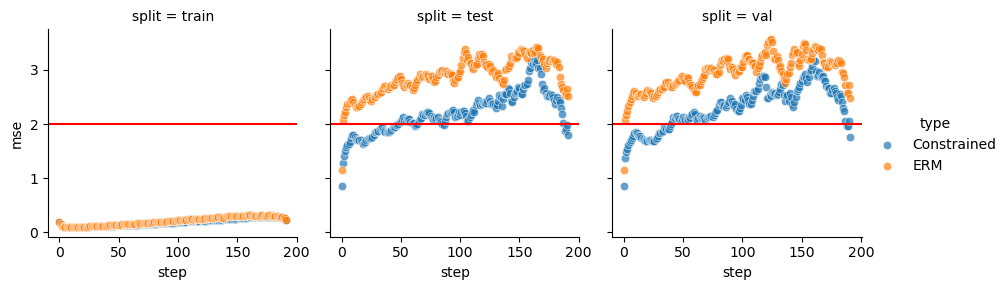

In [30]:
#df = df.query('split=="train"')
runs = api.runs(f"{workspace}/{project}",{"$and": [{"name": {"$in": [
    "jvqvoczj", #constraint mean (with \eps= 2, init=0)
    "gtwu3rrt", #ERM fixed bug
    #"v0f930e5", #dual init 0 probably garbage
]}},]})
df = runs_into_df(runs)
g = sns.FacetGrid(df, col="split", hue="type",col_wrap=3)
g.map(sns.scatterplot, "step", "mse", alpha=.7) 
g.add_legend()
# add the hline
data_summary=df.groupby(['run_id','model','data_path','split','constraint_level'])[['mse']].mean().reset_index()
# Pivot mse with columns based on split and reference
display(data_summary.pivot_table(index=['run_id','model','data_path','constraint_level'],columns=['split'],values=['mse']).reset_index())
for ax in g.axes:   
    ax.axhline(y=df.constraint_level[df.constraint_level>0].tolist()[0], color='r', linestyle='-')
plt.show()